<a href="https://colab.research.google.com/github/scaomath/wustl-math450/blob/main/Lectures/Math_450_Notebook_5_(GD).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coding lecture 5 of Math 450

Overall goal of the our class: make us learn machine learning in torch package.
- Build our own neural net using Torch's LEGO-like blocks.
- Write torch-like code from scratch.
- Write our own optimizer.

## Last week

- Explore MNIST dataset.
- Generator, iterator, `iter()` and `next()`
- `enumerate()`.
- `with`.

## Instructor's suggestions and tips
- How to debug a `for` loop in a cell environment or a vectorized operation.
- Good habit: keep a code repo of ourselves, a working copy of the HW, then a submit version. 
- Keep a list of typical solutions handy (to save some time Googling or trial and error of StackOverflow's answers). e.g., how to read a pickled file, how to get indices of entries from a list, etc.

## Today's goals
- f-string.
- `try: except:` flow control.
- More on matrix-vector multiplications (most important skill: dimension tracking). The terminology "broadcastable".
- Backprop `loss.backward()` vs hand computation.
- Gradient descent (manual implementation).

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")

import torch
import torch.nn as nn
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import torch
torch.cuda.is_available()

True

## f-string
New in Python 3, very handy tool.

In [ ]:
"this is a string"

'this is a string'

In [ ]:
# python 2
"this is an f-string: {:.2f}".format(23.33213123)

'this is an f-string: 23.33'

In [ ]:
# python 3
x = 23.33213123
f"this is an f-string: {x:.4f}"

'this is an f-string: 23.3321'

In [ ]:
# example of a timer
from time import time

start = time()
for i in range(10000):
   x += 1
print(f"Time elasped: {time() - start} seconds")

Time elasped: 0.0014984607696533203 seconds


In [ ]:
# print the counter of iterations
for i, item in enumerate(['apple', 'pear', 'orange']):
    print(f"Index: {i}, item: {item}")

Index: 0, item: apple
Index: 1, item: pear
Index: 2, item: orange


## Try, except

Often seen in many data loading routines.

In [ ]:
# this line of code will give us error
print(x1)
print(x) # the execution stops and this line won't get
# executed

NameError: ignored

In [ ]:
try:
  print(x1)
except:
  print(x)

10023.33213123


In [ ]:
try:
  print(x)
except:
  raise NameError("variable does not exist")

10023.33213123


## Debugging `for` loops

- How do we figure out what a `for` loop is doing?
- From `for` loop to vectorization.

In [ ]:
# load the mnist data
train = datasets.MNIST('../data', 
                       train=True, 
                       download=True, 
                       transform = transforms.ToTensor())

In [ ]:
idx = (train.targets==8)
labels_new = train.targets[idx]
data = train.train_data[idx].clone()/255.0

In [ ]:
n_data_all = len(data)
idx = np.random.choice(range(n_data_all), size=10)
data_new = data[idx].clone().detach()
print(data_new.shape)

torch.Size([10, 28, 28])


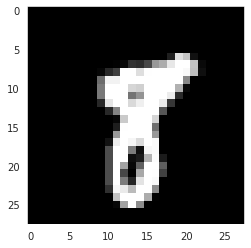

In [ ]:
i = 9
plt.imshow(data_new[i,:,:], cmap='gray'); 
# plot the i-th sample

In [ ]:
# problem 2 in HW, how to dissect this code
W0 = torch.randn(28*28, 14*14)
n_samples = len(data_new)
X0 = data_new
X1 = torch.zeros(n_samples, 14*14, 1)
for i in range(n_samples):
    sample = X0[i,:,:].view(-1,1)
    X1[i,:] = W0.T.mm(sample) 
    # X1 gets an assignment at each iteration 
X2 = X1.view(-1,14,14) # output
# the -1 in the first dim is just keeping
# the number of samples unchanged.

In [ ]:
for i in range(n_samples):
    print(i)
    sample = X0[i,:,:].view(-1,1)
    X1_tmp = W0.T.mm(sample)
    break

0


In [ ]:
print(sample.size(), W0.size(), W0.T.size())
# W0.T means transpose to a vector
print(X1_tmp.size())

torch.Size([784, 1]) torch.Size([784, 196]) torch.Size([196, 784])
torch.Size([196, 1])


In [ ]:
print(X0.size(),X1.size(), X2.size()) 
# 10: number of samples
# (14, 14): downsampled image size

torch.Size([10, 28, 28]) torch.Size([10, 196, 1]) torch.Size([10, 14, 14])


In [ ]:
torch.arange(9)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
torch.arange(9).view(3,3)

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])

In [ ]:
torch.arange(9).view(3,3).view(-1)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
X0 = X0.view(-1, 28*28) # (10, 784)
X1 = X0.mm(W0)
# print(X1.size(), X0.size(),W.size())
X2 = X1.view(-1, 14, 14)
print(X2.size())
# X1's desired dimension (10, 196) or (10, 196, 1)
# W's dimension is (784, 196)
# (10, 784) mm (784, 196) = (10, 196)

torch.Size([10, 14, 14])


In [ ]:
# example of vectorized functions, mean, sum
print(X1.mean())
print(X1.mean(dim=1))

tensor(-0.6267)
tensor([-0.0487, -1.8691, -0.3946, -0.1944, -1.4187, -0.3871, -0.4265, -0.2006,
        -1.1636, -0.1639])


## `torch.mm` and `*` in backprop

"broadcastable": the tensor involved in an operation can be automatically expanded to be of equal sizes (without making copies of the data) to let the operation go through.

General semantics
Two tensors are “broadcastable” 
- Each tensor has at least one dimension.
- When iterating over the dimension sizes, starting at the last dimension, the dimension sizes must either be equal, one of them is 1, or one of them does not exist.

In [ ]:
torch.manual_seed(42)
n_samples = len(data_new)

# X[i] is a row vector representing a sample
X = data_new.view(-1, 28*28).clone().detach()

# y[i] is a made-up label for i-th sample
y = torch.randn((n_samples, 1), requires_grad=False)

# W is the weight matrix transposed 
W = torch.randn((28*28, 1), requires_grad=True)
L = 0.5*(X.mm(W) - y).square().mean()

# backprop
L.backward()

# gradient
with torch.no_grad():
    gradW = W.grad

### Problem 4 in Coding HW 2
Implement
$$ 
\frac{\partial L}{ \partial (W^T)} = \frac{1}{10} \sum_{i=1}^{10} 
(W\boldsymbol{x}^{(i)} -y^{(i)}) * \boldsymbol{x}^{(i)}
$$ 

First let us look at a simpler function of $\boldsymbol{w}$
$$
f(z) = (z - y)^2
$$
and 
$$
z = \boldsymbol{w} \cdot \boldsymbol{x}
$$
then 
$$
\frac{\partial f}{\partial \boldsymbol{w}} = 2(z - y) \frac{\partial z}{\partial \boldsymbol{w}}  = 2(z-y) \boldsymbol{x}
$$
$z-y$ is a scalar, and $\boldsymbol{x}$ has the same shape with $\boldsymbol{w}$.

In [ ]:
# demo
torch.manual_seed(42)
x = torch.randn(10, requires_grad=False)
y = torch.randn(1, requires_grad=False)
w = torch.zeros(10, requires_grad=True)
f = (w.dot(x) - y).pow(2)
f.backward()

with torch.no_grad():
    print(w.grad)

tensor([-0.3602, -0.1378, -0.2508, -0.2464,  1.2012,  0.1993, -2.3624,  0.6825,
        -0.4939, -0.2860])


In [ ]:
# compute it by hand
with torch.no_grad(): # always use this when computing gradient by hand
  z = w.dot(x)
  gradw = 2*(z - y) * x
print(gradw)

tensor([-0.3602, -0.1378, -0.2508, -0.2464,  1.2012,  0.1993, -2.3624,  0.6825,
        -0.4939, -0.2860])


Consider multi-dimension
$$
f(z_1, z_2) = (z_1 - y_1)^2 + (z_2 - y_1)^2
$$
If we have 5 samples, each one has 3 features
For $W^T\in \mathbb{R}^{3\times 2 }$, $\boldsymbol{x} \in \mathbb{R}^{5\times 3} $
$$
\boldsymbol{z} = \boldsymbol{x} W^T 
$$
then 
$$
\frac{\partial f}{\partial W^T} = 2(\boldsymbol{z} - \boldsymbol{y}) \frac{\partial z}{\partial W^T} 
$$

## Full gradient descent code for 3-layer nn

In [ ]:
# N is the sample size (or current batch size); 
# D_in is input dimension;
# N_H is hidden dimension; 
# D_out is output dimension.
N, D_in, N_H, D_out = 64, 1000, 100, 3

# Create random Tensors to hold input and outputs.
# Setting requires_grad=False indicates that we do not need to compute gradients
# with respect to these Tensors during the backward pass.
X = torch.randn(N, D_in, requires_grad=False)
y = torch.randn(N, D_out, requires_grad=False)

# Create random Tensors for weights.
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
w1 = torch.randn(D_in, N_H, requires_grad=True)
w2 = torch.randn(N_H, D_out, requires_grad=True)

learning_rate = 1e-6

for m in range(1000):
    # Forward pass: compute predicted y using operations on Tensors; these
    # are exactly the same operations we used to compute the forward pass using
    # Tensors, but we do not need to keep references to intermediate values since
    # we are not implementing the backward pass by hand.
    y_pred = x.mm(w1).clamp(min=0).mm(w2)

    # Compute and print loss using operations on Tensors.
    # Now loss is a Tensor of shape (1,)
    # loss.item() gets the a scalar value held in the loss.
    loss = (y_pred - y).pow(2).mean()
    if m % 100 == 0:
        print(f"LS loss after {m}", 
              f"iterations is {loss.item()}",)

    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call w1.grad and w2.grad will be Tensors holding the gradient
    # of the loss with respect to w1 and w2 respectively.
    loss.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    # An alternative way is to operate on weight.data and weight.grad.data.
    # Recall that tensor.data gives a tensor that shares the storage with
    # tensor, but doesn't track history.
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad

        # Manually zero the gradients after updating weights
        w1.grad.zero_()
        w2.grad.zero_()